<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:14:32] /work/mxnet/src/storage/storage.cc:205: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


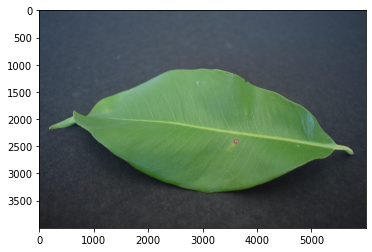

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

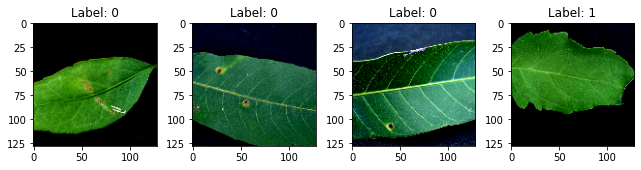

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:14:37] /work/mxnet/src/storage/storage.cc:205: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:14:39] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:107: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2174756337475228 samples/sec                   batch loss = 0.999366283416748 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2596671659370322 samples/sec                   batch loss = 0.6283615231513977 | accuracy = 0.525


Epoch[1] Batch[15] Speed: 1.257443777202449 samples/sec                   batch loss = 0.7010894417762756 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.257595812395536 samples/sec                   batch loss = 0.7572019696235657 | accuracy = 0.55


Epoch[1] Batch[25] Speed: 1.2625579514690923 samples/sec                   batch loss = 0.8762422204017639 | accuracy = 0.57


Epoch[1] Batch[30] Speed: 1.2715458575968828 samples/sec                   batch loss = 0.5402516722679138 | accuracy = 0.5583333333333333


Epoch[1] Batch[35] Speed: 1.260962422796452 samples/sec                   batch loss = 0.9121989011764526 | accuracy = 0.5714285714285714


Epoch[1] Batch[40] Speed: 1.25681962132588 samples/sec                   batch loss = 0.5781002640724182 | accuracy = 0.575


Epoch[1] Batch[45] Speed: 1.256986291106545 samples/sec                   batch loss = 0.7805785536766052 | accuracy = 0.5777777777777777


Epoch[1] Batch[50] Speed: 1.26241668303892 samples/sec                   batch loss = 0.21674570441246033 | accuracy = 0.59


Epoch[1] Batch[55] Speed: 1.2619344046261558 samples/sec                   batch loss = 0.5430623292922974 | accuracy = 0.6


Epoch[1] Batch[60] Speed: 1.2652313736539038 samples/sec                   batch loss = 0.6906833052635193 | accuracy = 0.6041666666666666


Epoch[1] Batch[65] Speed: 1.2699159150426065 samples/sec                   batch loss = 1.0670111179351807 | accuracy = 0.6038461538461538


Epoch[1] Batch[70] Speed: 1.2616450626110656 samples/sec                   batch loss = 0.710083544254303 | accuracy = 0.6035714285714285


Epoch[1] Batch[75] Speed: 1.2589702255911726 samples/sec                   batch loss = 0.5777039527893066 | accuracy = 0.61


Epoch[1] Batch[80] Speed: 1.2623035580897441 samples/sec                   batch loss = 0.6608142256736755 | accuracy = 0.61875


Epoch[1] Batch[85] Speed: 1.27422132385767 samples/sec                   batch loss = 0.43472641706466675 | accuracy = 0.6176470588235294


Epoch[1] Batch[90] Speed: 1.2681575609358984 samples/sec                   batch loss = 0.36222368478775024 | accuracy = 0.625


Epoch[1] Batch[95] Speed: 1.2563270269179407 samples/sec                   batch loss = 1.5242571830749512 | accuracy = 0.6263157894736842


Epoch[1] Batch[100] Speed: 1.2566155345999992 samples/sec                   batch loss = 1.4210399389266968 | accuracy = 0.6375


Epoch[1] Batch[105] Speed: 1.2661423906969127 samples/sec                   batch loss = 0.6229782700538635 | accuracy = 0.6261904761904762


Epoch[1] Batch[110] Speed: 1.2694988756109153 samples/sec                   batch loss = 0.40497082471847534 | accuracy = 0.625


Epoch[1] Batch[115] Speed: 1.272641569975118 samples/sec                   batch loss = 0.6554184556007385 | accuracy = 0.6347826086956522


Epoch[1] Batch[120] Speed: 1.2768199320463827 samples/sec                   batch loss = 0.4801160395145416 | accuracy = 0.64375


Epoch[1] Batch[125] Speed: 1.2725137682593932 samples/sec                   batch loss = 0.20493024587631226 | accuracy = 0.648


Epoch[1] Batch[130] Speed: 1.2731609560703279 samples/sec                   batch loss = 0.5114878416061401 | accuracy = 0.6480769230769231


Epoch[1] Batch[135] Speed: 1.2708431269383005 samples/sec                   batch loss = 0.6524149179458618 | accuracy = 0.6462962962962963


Epoch[1] Batch[140] Speed: 1.2575548073436897 samples/sec                   batch loss = 0.7680298089981079 | accuracy = 0.6446428571428572


Epoch[1] Batch[145] Speed: 1.2719149673966532 samples/sec                   batch loss = 0.7929750680923462 | accuracy = 0.6413793103448275


Epoch[1] Batch[150] Speed: 1.2732381565218105 samples/sec                   batch loss = 0.4362303614616394 | accuracy = 0.6433333333333333


Epoch[1] Batch[155] Speed: 1.268924021949524 samples/sec                   batch loss = 1.1693994998931885 | accuracy = 0.646774193548387


Epoch[1] Batch[160] Speed: 1.267123239044627 samples/sec                   batch loss = 1.2013514041900635 | accuracy = 0.646875


Epoch[1] Batch[165] Speed: 1.2708034673998454 samples/sec                   batch loss = 0.6646922826766968 | accuracy = 0.646969696969697


Epoch[1] Batch[170] Speed: 1.2657338415617674 samples/sec                   batch loss = 1.383074402809143 | accuracy = 0.6455882352941177


Epoch[1] Batch[175] Speed: 1.2524309815052135 samples/sec                   batch loss = 0.6284570693969727 | accuracy = 0.6514285714285715


Epoch[1] Batch[180] Speed: 1.2553251491207862 samples/sec                   batch loss = 0.3144226670265198 | accuracy = 0.6555555555555556


Epoch[1] Batch[185] Speed: 1.2542850136663497 samples/sec                   batch loss = 0.5121626257896423 | accuracy = 0.6581081081081082


Epoch[1] Batch[190] Speed: 1.267971336976446 samples/sec                   batch loss = 0.3848329484462738 | accuracy = 0.6552631578947369


Epoch[1] Batch[195] Speed: 1.2643607320853574 samples/sec                   batch loss = 0.8090968132019043 | accuracy = 0.6551282051282051


Epoch[1] Batch[200] Speed: 1.2636527839885043 samples/sec                   batch loss = 0.6431145668029785 | accuracy = 0.65375


Epoch[1] Batch[205] Speed: 1.268381332044077 samples/sec                   batch loss = 0.5661804676055908 | accuracy = 0.6573170731707317


Epoch[1] Batch[210] Speed: 1.2701147297723188 samples/sec                   batch loss = 0.46409690380096436 | accuracy = 0.6607142857142857


Epoch[1] Batch[215] Speed: 1.2640608477318662 samples/sec                   batch loss = 0.46803009510040283 | accuracy = 0.6616279069767442


Epoch[1] Batch[220] Speed: 1.257681224606066 samples/sec                   batch loss = 0.3309764862060547 | accuracy = 0.6602272727272728


Epoch[1] Batch[225] Speed: 1.264483470390764 samples/sec                   batch loss = 0.6877452731132507 | accuracy = 0.6577777777777778


Epoch[1] Batch[230] Speed: 1.2682027114712322 samples/sec                   batch loss = 1.1192842721939087 | accuracy = 0.658695652173913


Epoch[1] Batch[235] Speed: 1.25964702107113 samples/sec                   batch loss = 0.3096488118171692 | accuracy = 0.6617021276595745


Epoch[1] Batch[240] Speed: 1.26510276631439 samples/sec                   batch loss = 0.7939698696136475 | accuracy = 0.6614583333333334


Epoch[1] Batch[245] Speed: 1.2660685323876038 samples/sec                   batch loss = 0.6818186044692993 | accuracy = 0.6622448979591836


Epoch[1] Batch[250] Speed: 1.2629273748197791 samples/sec                   batch loss = 0.42394325137138367 | accuracy = 0.661


Epoch[1] Batch[255] Speed: 1.2689676913957504 samples/sec                   batch loss = 0.683469295501709 | accuracy = 0.6607843137254902


Epoch[1] Batch[260] Speed: 1.2666910080818934 samples/sec                   batch loss = 0.36292392015457153 | accuracy = 0.6586538461538461


Epoch[1] Batch[265] Speed: 1.272211162040019 samples/sec                   batch loss = 0.34590116143226624 | accuracy = 0.660377358490566


Epoch[1] Batch[270] Speed: 1.2713394654699037 samples/sec                   batch loss = 0.8760917782783508 | accuracy = 0.6592592592592592


Epoch[1] Batch[275] Speed: 1.2668369654597502 samples/sec                   batch loss = 0.38568106293678284 | accuracy = 0.6627272727272727


Epoch[1] Batch[280] Speed: 1.2680380377792924 samples/sec                   batch loss = 0.45809248089790344 | accuracy = 0.6642857142857143


Epoch[1] Batch[285] Speed: 1.2589452850228335 samples/sec                   batch loss = 1.1278619766235352 | accuracy = 0.6649122807017543


Epoch[1] Batch[290] Speed: 1.2663530249687303 samples/sec                   batch loss = 0.3577284812927246 | accuracy = 0.6663793103448276


Epoch[1] Batch[295] Speed: 1.2707358978685965 samples/sec                   batch loss = 0.8356348276138306 | accuracy = 0.6661016949152543


Epoch[1] Batch[300] Speed: 1.258158747337874 samples/sec                   batch loss = 0.4020623564720154 | accuracy = 0.6675


Epoch[1] Batch[305] Speed: 1.2711735909642292 samples/sec                   batch loss = 1.0911760330200195 | accuracy = 0.6663934426229509


Epoch[1] Batch[310] Speed: 1.2609631809804978 samples/sec                   batch loss = 0.3534995913505554 | accuracy = 0.6685483870967742


Epoch[1] Batch[315] Speed: 1.2579037656401828 samples/sec                   batch loss = 0.41034331917762756 | accuracy = 0.6706349206349206


Epoch[1] Batch[320] Speed: 1.2689008927571326 samples/sec                   batch loss = 0.2805783748626709 | accuracy = 0.67109375


Epoch[1] Batch[325] Speed: 1.2535483996299999 samples/sec                   batch loss = 0.43911129236221313 | accuracy = 0.67


Epoch[1] Batch[330] Speed: 1.2597143623008094 samples/sec                   batch loss = 1.8092598915100098 | accuracy = 0.6696969696969697


Epoch[1] Batch[335] Speed: 1.2526198695939232 samples/sec                   batch loss = 1.0620126724243164 | accuracy = 0.6694029850746268


Epoch[1] Batch[340] Speed: 1.259893154145496 samples/sec                   batch loss = 0.4197927713394165 | accuracy = 0.6683823529411764


Epoch[1] Batch[345] Speed: 1.2637333095308307 samples/sec                   batch loss = 0.29093530774116516 | accuracy = 0.6717391304347826


Epoch[1] Batch[350] Speed: 1.2676310421369126 samples/sec                   batch loss = 0.42088380455970764 | accuracy = 0.6721428571428572


Epoch[1] Batch[355] Speed: 1.2643641623354254 samples/sec                   batch loss = 0.47253721952438354 | accuracy = 0.671830985915493


Epoch[1] Batch[360] Speed: 1.2558389546691913 samples/sec                   batch loss = 0.3654415011405945 | accuracy = 0.6729166666666667


Epoch[1] Batch[365] Speed: 1.2535829617726004 samples/sec                   batch loss = 0.34597867727279663 | accuracy = 0.6732876712328767


Epoch[1] Batch[370] Speed: 1.2656527744385637 samples/sec                   batch loss = 0.5403355360031128 | accuracy = 0.6736486486486486


Epoch[1] Batch[375] Speed: 1.2749937778642437 samples/sec                   batch loss = 0.5911091566085815 | accuracy = 0.6726666666666666


Epoch[1] Batch[380] Speed: 1.273437529649528 samples/sec                   batch loss = 1.0079874992370605 | accuracy = 0.6730263157894737


Epoch[1] Batch[385] Speed: 1.2705779748973012 samples/sec                   batch loss = 0.2906513214111328 | accuracy = 0.672077922077922


Epoch[1] Batch[390] Speed: 1.268353811801307 samples/sec                   batch loss = 0.7564088106155396 | accuracy = 0.6743589743589744


Epoch[1] Batch[395] Speed: 1.2656645185022124 samples/sec                   batch loss = 0.4425845146179199 | accuracy = 0.6746835443037975


Epoch[1] Batch[400] Speed: 1.2563488532641323 samples/sec                   batch loss = 0.3403404951095581 | accuracy = 0.67625


Epoch[1] Batch[405] Speed: 1.2519006228903318 samples/sec                   batch loss = 0.6739717125892639 | accuracy = 0.6771604938271605


Epoch[1] Batch[410] Speed: 1.2708637277724804 samples/sec                   batch loss = 0.39054685831069946 | accuracy = 0.6786585365853659


Epoch[1] Batch[415] Speed: 1.2675953179438246 samples/sec                   batch loss = 0.3156059980392456 | accuracy = 0.6783132530120481


Epoch[1] Batch[420] Speed: 1.2648396225568732 samples/sec                   batch loss = 0.4659714698791504 | accuracy = 0.6785714285714286


Epoch[1] Batch[425] Speed: 1.2540428476937966 samples/sec                   batch loss = 0.3922664225101471 | accuracy = 0.6788235294117647


Epoch[1] Batch[430] Speed: 1.2662501838744884 samples/sec                   batch loss = 0.5070033073425293 | accuracy = 0.6808139534883721


Epoch[1] Batch[435] Speed: 1.2586191646888387 samples/sec                   batch loss = 0.3838099539279938 | accuracy = 0.6821839080459771


Epoch[1] Batch[440] Speed: 1.26785002850491 samples/sec                   batch loss = 0.24480542540550232 | accuracy = 0.6829545454545455


Epoch[1] Batch[445] Speed: 1.2672230633592045 samples/sec                   batch loss = 0.9458591938018799 | accuracy = 0.6820224719101123


Epoch[1] Batch[450] Speed: 1.27692682976951 samples/sec                   batch loss = 0.22067217528820038 | accuracy = 0.6827777777777778


Epoch[1] Batch[455] Speed: 1.2763556206434188 samples/sec                   batch loss = 0.2245810329914093 | accuracy = 0.6846153846153846


Epoch[1] Batch[460] Speed: 1.2705487235189952 samples/sec                   batch loss = 0.5016978979110718 | accuracy = 0.6842391304347826


Epoch[1] Batch[465] Speed: 1.271851618362399 samples/sec                   batch loss = 0.7350541353225708 | accuracy = 0.6827956989247311


Epoch[1] Batch[470] Speed: 1.2726957293517696 samples/sec                   batch loss = 0.7132275700569153 | accuracy = 0.6808510638297872


Epoch[1] Batch[475] Speed: 1.269991280418897 samples/sec                   batch loss = 0.3334343433380127 | accuracy = 0.6821052631578948


Epoch[1] Batch[480] Speed: 1.2666250226678946 samples/sec                   batch loss = 0.6365256905555725 | accuracy = 0.6817708333333333


Epoch[1] Batch[485] Speed: 1.2703832476641477 samples/sec                   batch loss = 0.7191933989524841 | accuracy = 0.681958762886598


Epoch[1] Batch[490] Speed: 1.2576128750555169 samples/sec                   batch loss = 0.2693936228752136 | accuracy = 0.6826530612244898


Epoch[1] Batch[495] Speed: 1.2701429034319234 samples/sec                   batch loss = 0.7201786637306213 | accuracy = 0.6823232323232323


Epoch[1] Batch[500] Speed: 1.2713140324225234 samples/sec                   batch loss = 0.4615410268306732 | accuracy = 0.6825


Epoch[1] Batch[505] Speed: 1.2704643446882824 samples/sec                   batch loss = 0.6647821068763733 | accuracy = 0.6821782178217822


Epoch[1] Batch[510] Speed: 1.271694960258244 samples/sec                   batch loss = 0.9241584539413452 | accuracy = 0.6833333333333333


Epoch[1] Batch[515] Speed: 1.2738635449046873 samples/sec                   batch loss = 0.9200664162635803 | accuracy = 0.6825242718446602


Epoch[1] Batch[520] Speed: 1.265340252378469 samples/sec                   batch loss = 0.7133224606513977 | accuracy = 0.6817307692307693


Epoch[1] Batch[525] Speed: 1.2641417110458055 samples/sec                   batch loss = 0.42226263880729675 | accuracy = 0.6823809523809524


Epoch[1] Batch[530] Speed: 1.2678543400195408 samples/sec                   batch loss = 1.0446826219558716 | accuracy = 0.6834905660377358


Epoch[1] Batch[535] Speed: 1.2693820768161097 samples/sec                   batch loss = 0.6837412118911743 | accuracy = 0.6827102803738317


Epoch[1] Batch[540] Speed: 1.2552652262639374 samples/sec                   batch loss = 0.2990356981754303 | accuracy = 0.6837962962962963


Epoch[1] Batch[545] Speed: 1.250990948495732 samples/sec                   batch loss = 0.5510082840919495 | accuracy = 0.6848623853211009


Epoch[1] Batch[550] Speed: 1.2572066078593997 samples/sec                   batch loss = 0.9918507933616638 | accuracy = 0.6859090909090909


Epoch[1] Batch[555] Speed: 1.2662949119631817 samples/sec                   batch loss = 0.4826733469963074 | accuracy = 0.686036036036036


Epoch[1] Batch[560] Speed: 1.2538134247707804 samples/sec                   batch loss = 0.7949949502944946 | accuracy = 0.684375


Epoch[1] Batch[565] Speed: 1.2662988306001244 samples/sec                   batch loss = 0.22043476998806 | accuracy = 0.6836283185840708


Epoch[1] Batch[570] Speed: 1.2611946592848726 samples/sec                   batch loss = 0.3811090588569641 | accuracy = 0.6850877192982456


Epoch[1] Batch[575] Speed: 1.267438844804463 samples/sec                   batch loss = 0.3169268071651459 | accuracy = 0.6856521739130435


Epoch[1] Batch[580] Speed: 1.2654429457159346 samples/sec                   batch loss = 0.560624361038208 | accuracy = 0.684051724137931


Epoch[1] Batch[585] Speed: 1.2555948727904263 samples/sec                   batch loss = 0.9332080483436584 | accuracy = 0.6854700854700855


Epoch[1] Batch[590] Speed: 1.2564427528331008 samples/sec                   batch loss = 0.38603323698043823 | accuracy = 0.6847457627118644


Epoch[1] Batch[595] Speed: 1.2523400176192723 samples/sec                   batch loss = 0.34882652759552 | accuracy = 0.6831932773109244


Epoch[1] Batch[600] Speed: 1.2612689930290921 samples/sec                   batch loss = 0.3869147300720215 | accuracy = 0.68375


Epoch[1] Batch[605] Speed: 1.2528545629097096 samples/sec                   batch loss = 0.6547000408172607 | accuracy = 0.6826446280991736


Epoch[1] Batch[610] Speed: 1.2523623600422649 samples/sec                   batch loss = 0.3074416518211365 | accuracy = 0.6836065573770492


Epoch[1] Batch[615] Speed: 1.2634222102803907 samples/sec                   batch loss = 0.5414133667945862 | accuracy = 0.6841463414634147


Epoch[1] Batch[620] Speed: 1.2702162761996243 samples/sec                   batch loss = 1.0596657991409302 | accuracy = 0.6850806451612903


Epoch[1] Batch[625] Speed: 1.268556645803084 samples/sec                   batch loss = 0.43998998403549194 | accuracy = 0.686


Epoch[1] Batch[630] Speed: 1.2609476383897957 samples/sec                   batch loss = 0.4011276960372925 | accuracy = 0.6849206349206349


Epoch[1] Batch[635] Speed: 1.2600703878859352 samples/sec                   batch loss = 0.30455777049064636 | accuracy = 0.6862204724409449


Epoch[1] Batch[640] Speed: 1.262521467555264 samples/sec                   batch loss = 0.2790970206260681 | accuracy = 0.686328125


Epoch[1] Batch[645] Speed: 1.2724135912074523 samples/sec                   batch loss = 0.7911399006843567 | accuracy = 0.6864341085271318


Epoch[1] Batch[650] Speed: 1.2697099555724543 samples/sec                   batch loss = 0.2139064371585846 | accuracy = 0.688076923076923


Epoch[1] Batch[655] Speed: 1.272000889183666 samples/sec                   batch loss = 0.2816416025161743 | accuracy = 0.6889312977099237


Epoch[1] Batch[660] Speed: 1.2698118217148726 samples/sec                   batch loss = 0.5455569624900818 | accuracy = 0.6890151515151515


Epoch[1] Batch[665] Speed: 1.2697346518060355 samples/sec                   batch loss = 0.1797942817211151 | accuracy = 0.6898496240601504


Epoch[1] Batch[670] Speed: 1.2730139242878702 samples/sec                   batch loss = 0.5391421914100647 | accuracy = 0.6902985074626866


Epoch[1] Batch[675] Speed: 1.2668814480184702 samples/sec                   batch loss = 1.2821632623672485 | accuracy = 0.6896296296296296


Epoch[1] Batch[680] Speed: 1.2719879664224367 samples/sec                   batch loss = 0.2323346883058548 | accuracy = 0.6908088235294118


Epoch[1] Batch[685] Speed: 1.2642040085684756 samples/sec                   batch loss = 0.6845189929008484 | accuracy = 0.6905109489051094


Epoch[1] Batch[690] Speed: 1.2609288740652134 samples/sec                   batch loss = 0.7607372403144836 | accuracy = 0.6902173913043478


Epoch[1] Batch[695] Speed: 1.2552193018026983 samples/sec                   batch loss = 0.7465662956237793 | accuracy = 0.6906474820143885


Epoch[1] Batch[700] Speed: 1.2680665027581244 samples/sec                   batch loss = 0.3554627299308777 | accuracy = 0.6907142857142857


Epoch[1] Batch[705] Speed: 1.2697414746702818 samples/sec                   batch loss = 0.29747718572616577 | accuracy = 0.6907801418439716


Epoch[1] Batch[710] Speed: 1.275835371675329 samples/sec                   batch loss = 0.2867978513240814 | accuracy = 0.6904929577464789


Epoch[1] Batch[715] Speed: 1.2763895097759663 samples/sec                   batch loss = 0.22448791563510895 | accuracy = 0.6916083916083916


Epoch[1] Batch[720] Speed: 1.2585632699148739 samples/sec                   batch loss = 0.700371503829956 | accuracy = 0.6913194444444445


Epoch[1] Batch[725] Speed: 1.2589754216672906 samples/sec                   batch loss = 1.4183686971664429 | accuracy = 0.6917241379310345


Epoch[1] Batch[730] Speed: 1.2711393040728818 samples/sec                   batch loss = 0.23566000163555145 | accuracy = 0.6928082191780822


Epoch[1] Batch[735] Speed: 1.2623321461078167 samples/sec                   batch loss = 0.815389096736908 | accuracy = 0.6928571428571428


Epoch[1] Batch[740] Speed: 1.2547049708845934 samples/sec                   batch loss = 0.5752496719360352 | accuracy = 0.6922297297297297


Epoch[1] Batch[745] Speed: 1.271653319797099 samples/sec                   batch loss = 0.5842978358268738 | accuracy = 0.6929530201342282


Epoch[1] Batch[750] Speed: 1.2692574254991342 samples/sec                   batch loss = 0.6053561568260193 | accuracy = 0.6943333333333334


Epoch[1] Batch[755] Speed: 1.2693368422677296 samples/sec                   batch loss = 0.4694310426712036 | accuracy = 0.6947019867549669


Epoch[1] Batch[760] Speed: 1.2717564620383273 samples/sec                   batch loss = 0.6827746033668518 | accuracy = 0.69375


Epoch[1] Batch[765] Speed: 1.2725543068092953 samples/sec                   batch loss = 0.3787572383880615 | accuracy = 0.6941176470588235


Epoch[1] Batch[770] Speed: 1.2690420803399116 samples/sec                   batch loss = 0.48254841566085815 | accuracy = 0.6951298701298702


Epoch[1] Batch[775] Speed: 1.2706334022553016 samples/sec                   batch loss = 0.2484072744846344 | accuracy = 0.6958064516129032


Epoch[1] Batch[780] Speed: 1.2630751286265514 samples/sec                   batch loss = 0.47553369402885437 | accuracy = 0.6967948717948718


Epoch[1] Batch[785] Speed: 1.2569927892982944 samples/sec                   batch loss = 0.9668081402778625 | accuracy = 0.6971337579617835


[Epoch 1] training: accuracy=0.6973350253807107
[Epoch 1] time cost: 650.7271480560303
[Epoch 1] validation: validation accuracy=0.7777777777777778


Epoch[2] Batch[5] Speed: 1.2671968376153138 samples/sec                   batch loss = 0.4705874025821686 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2686046065852714 samples/sec                   batch loss = 0.3021025061607361 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.2554205866720305 samples/sec                   batch loss = 1.6397429704666138 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.266447852376822 samples/sec                   batch loss = 0.48926842212677 | accuracy = 0.6875


Epoch[2] Batch[25] Speed: 1.2733595318541848 samples/sec                   batch loss = 0.13705399632453918 | accuracy = 0.73


Epoch[2] Batch[30] Speed: 1.273663651601412 samples/sec                   batch loss = 1.8496067523956299 | accuracy = 0.7166666666666667


Epoch[2] Batch[35] Speed: 1.2655923389236334 samples/sec                   batch loss = 0.2885175049304962 | accuracy = 0.7214285714285714


Epoch[2] Batch[40] Speed: 1.2715672522101504 samples/sec                   batch loss = 0.34485161304473877 | accuracy = 0.7375


Epoch[2] Batch[45] Speed: 1.2714010292175972 samples/sec                   batch loss = 0.43296879529953003 | accuracy = 0.7333333333333333


Epoch[2] Batch[50] Speed: 1.2746302389120296 samples/sec                   batch loss = 0.33484211564064026 | accuracy = 0.725


Epoch[2] Batch[55] Speed: 1.2569932601843652 samples/sec                   batch loss = 0.54085373878479 | accuracy = 0.7363636363636363


Epoch[2] Batch[60] Speed: 1.2654149801723784 samples/sec                   batch loss = 0.9472197890281677 | accuracy = 0.7375


Epoch[2] Batch[65] Speed: 1.2745769799030127 samples/sec                   batch loss = 0.2712690830230713 | accuracy = 0.7346153846153847


Epoch[2] Batch[70] Speed: 1.2669088087351774 samples/sec                   batch loss = 0.43926241993904114 | accuracy = 0.7392857142857143


Epoch[2] Batch[75] Speed: 1.2662283944118211 samples/sec                   batch loss = 0.33467334508895874 | accuracy = 0.7366666666666667


Epoch[2] Batch[80] Speed: 1.2679975947883453 samples/sec                   batch loss = 0.11086031794548035 | accuracy = 0.740625


Epoch[2] Batch[85] Speed: 1.2722193621604807 samples/sec                   batch loss = 0.24103567004203796 | accuracy = 0.7411764705882353


Epoch[2] Batch[90] Speed: 1.269976956463749 samples/sec                   batch loss = 1.2097961902618408 | accuracy = 0.7361111111111112


Epoch[2] Batch[95] Speed: 1.2592160942212054 samples/sec                   batch loss = 0.40250834822654724 | accuracy = 0.7394736842105263


Epoch[2] Batch[100] Speed: 1.2633701691698425 samples/sec                   batch loss = 0.641464352607727 | accuracy = 0.74


Epoch[2] Batch[105] Speed: 1.2632889289138995 samples/sec                   batch loss = 0.603040337562561 | accuracy = 0.7428571428571429


Epoch[2] Batch[110] Speed: 1.2652223092238322 samples/sec                   batch loss = 0.9152253270149231 | accuracy = 0.7431818181818182


Epoch[2] Batch[115] Speed: 1.2673163936977183 samples/sec                   batch loss = 0.21177877485752106 | accuracy = 0.741304347826087


Epoch[2] Batch[120] Speed: 1.2726494860313025 samples/sec                   batch loss = 0.35117286443710327 | accuracy = 0.7416666666666667


Epoch[2] Batch[125] Speed: 1.256564711500516 samples/sec                   batch loss = 0.7047536373138428 | accuracy = 0.74


Epoch[2] Batch[130] Speed: 1.2596029505126638 samples/sec                   batch loss = 0.942523181438446 | accuracy = 0.7346153846153847


Epoch[2] Batch[135] Speed: 1.2587888621766616 samples/sec                   batch loss = 0.7912417054176331 | accuracy = 0.7333333333333333


Epoch[2] Batch[140] Speed: 1.2660779911207396 samples/sec                   batch loss = 0.5799887776374817 | accuracy = 0.7285714285714285


Epoch[2] Batch[145] Speed: 1.2723647630255879 samples/sec                   batch loss = 1.2073155641555786 | accuracy = 0.7258620689655172


Epoch[2] Batch[150] Speed: 1.2751133560951222 samples/sec                   batch loss = 0.9205385446548462 | accuracy = 0.7283333333333334


Epoch[2] Batch[155] Speed: 1.2676294139127355 samples/sec                   batch loss = 0.27453893423080444 | accuracy = 0.7322580645161291


Epoch[2] Batch[160] Speed: 1.265739762064811 samples/sec                   batch loss = 0.4619978368282318 | accuracy = 0.7296875


Epoch[2] Batch[165] Speed: 1.2668601151327463 samples/sec                   batch loss = 0.5094826221466064 | accuracy = 0.7318181818181818


Epoch[2] Batch[170] Speed: 1.2621014843813474 samples/sec                   batch loss = 1.0928611755371094 | accuracy = 0.7279411764705882


Epoch[2] Batch[175] Speed: 1.2602661315480956 samples/sec                   batch loss = 0.9662063121795654 | accuracy = 0.7271428571428571


Epoch[2] Batch[180] Speed: 1.251136388889676 samples/sec                   batch loss = 0.80619877576828 | accuracy = 0.7319444444444444


Epoch[2] Batch[185] Speed: 1.2501776098211412 samples/sec                   batch loss = 0.7150935530662537 | accuracy = 0.7324324324324324


Epoch[2] Batch[190] Speed: 1.2644038974218912 samples/sec                   batch loss = 0.21691663563251495 | accuracy = 0.7302631578947368


Epoch[2] Batch[195] Speed: 1.261516139859938 samples/sec                   batch loss = 0.1580062061548233 | accuracy = 0.732051282051282


Epoch[2] Batch[200] Speed: 1.2658286717631642 samples/sec                   batch loss = 0.5283695459365845 | accuracy = 0.73125


Epoch[2] Batch[205] Speed: 1.2718511362782658 samples/sec                   batch loss = 0.13158230483531952 | accuracy = 0.7304878048780488


Epoch[2] Batch[210] Speed: 1.261975790716154 samples/sec                   batch loss = 0.5264744758605957 | accuracy = 0.7333333333333333


Epoch[2] Batch[215] Speed: 1.2608000976342848 samples/sec                   batch loss = 0.7475147843360901 | accuracy = 0.7348837209302326


Epoch[2] Batch[220] Speed: 1.2745747528050426 samples/sec                   batch loss = 0.2791093587875366 | accuracy = 0.7375


Epoch[2] Batch[225] Speed: 1.2667108050467548 samples/sec                   batch loss = 0.34547871351242065 | accuracy = 0.7388888888888889


Epoch[2] Batch[230] Speed: 1.2724301897828287 samples/sec                   batch loss = 0.34380626678466797 | accuracy = 0.741304347826087


Epoch[2] Batch[235] Speed: 1.2616783648221197 samples/sec                   batch loss = 0.399421751499176 | accuracy = 0.7425531914893617


Epoch[2] Batch[240] Speed: 1.2624695006209927 samples/sec                   batch loss = 0.47057151794433594 | accuracy = 0.74375


Epoch[2] Batch[245] Speed: 1.264432580655056 samples/sec                   batch loss = 0.6308510899543762 | accuracy = 0.7408163265306122


Epoch[2] Batch[250] Speed: 1.2716415607162181 samples/sec                   batch loss = 0.576707661151886 | accuracy = 0.739


Epoch[2] Batch[255] Speed: 1.2694995480346203 samples/sec                   batch loss = 0.3606529235839844 | accuracy = 0.7392156862745098


Epoch[2] Batch[260] Speed: 1.2692639551607658 samples/sec                   batch loss = 0.5870795845985413 | accuracy = 0.7384615384615385


Epoch[2] Batch[265] Speed: 1.2524639860584643 samples/sec                   batch loss = 0.22270894050598145 | accuracy = 0.7424528301886792


Epoch[2] Batch[270] Speed: 1.257986767202337 samples/sec                   batch loss = 0.4034835398197174 | accuracy = 0.7435185185185185


Epoch[2] Batch[275] Speed: 1.275177708931077 samples/sec                   batch loss = 0.24592100083827972 | accuracy = 0.7472727272727273


Epoch[2] Batch[280] Speed: 1.270438561830874 samples/sec                   batch loss = 0.578863263130188 | accuracy = 0.7464285714285714


Epoch[2] Batch[285] Speed: 1.2654205159156429 samples/sec                   batch loss = 0.5892887115478516 | accuracy = 0.7456140350877193


Epoch[2] Batch[290] Speed: 1.2705371772930507 samples/sec                   batch loss = 0.7461139559745789 | accuracy = 0.7422413793103448


Epoch[2] Batch[295] Speed: 1.267308160930428 samples/sec                   batch loss = 0.48249250650405884 | accuracy = 0.7415254237288136


Epoch[2] Batch[300] Speed: 1.2566801988191239 samples/sec                   batch loss = 0.6211831569671631 | accuracy = 0.7425


Epoch[2] Batch[305] Speed: 1.259880097785322 samples/sec                   batch loss = 0.6556693911552429 | accuracy = 0.7434426229508196


Epoch[2] Batch[310] Speed: 1.2561581806014297 samples/sec                   batch loss = 0.6832509636878967 | accuracy = 0.7419354838709677


Epoch[2] Batch[315] Speed: 1.2551238009540076 samples/sec                   batch loss = 0.7584471106529236 | accuracy = 0.7428571428571429


Epoch[2] Batch[320] Speed: 1.2684521038667218 samples/sec                   batch loss = 0.6133620142936707 | accuracy = 0.74375


Epoch[2] Batch[325] Speed: 1.25414812168003 samples/sec                   batch loss = 0.29313206672668457 | accuracy = 0.7461538461538462


Epoch[2] Batch[330] Speed: 1.2638564020881349 samples/sec                   batch loss = 0.2378845363855362 | accuracy = 0.7477272727272727


Epoch[2] Batch[335] Speed: 1.2616048366435653 samples/sec                   batch loss = 0.5094243884086609 | accuracy = 0.7455223880597015


Epoch[2] Batch[340] Speed: 1.2624145932254875 samples/sec                   batch loss = 0.5565815567970276 | accuracy = 0.7455882352941177


Epoch[2] Batch[345] Speed: 1.2710101669655702 samples/sec                   batch loss = 0.5282490849494934 | accuracy = 0.7463768115942029


Epoch[2] Batch[350] Speed: 1.2756207955218433 samples/sec                   batch loss = 0.3430212438106537 | accuracy = 0.745


Epoch[2] Batch[355] Speed: 1.2687884258824063 samples/sec                   batch loss = 0.2953408658504486 | accuracy = 0.745774647887324


Epoch[2] Batch[360] Speed: 1.2756196316527513 samples/sec                   batch loss = 0.45642316341400146 | accuracy = 0.7472222222222222


Epoch[2] Batch[365] Speed: 1.259279986645514 samples/sec                   batch loss = 0.18294104933738708 | accuracy = 0.7479452054794521


Epoch[2] Batch[370] Speed: 1.2619999022126274 samples/sec                   batch loss = 0.2656545341014862 | accuracy = 0.7506756756756757


Epoch[2] Batch[375] Speed: 1.270671126417236 samples/sec                   batch loss = 0.4525581896305084 | accuracy = 0.7493333333333333


Epoch[2] Batch[380] Speed: 1.2681522887900167 samples/sec                   batch loss = 0.6113358736038208 | accuracy = 0.7493421052631579


Epoch[2] Batch[385] Speed: 1.2646020383973673 samples/sec                   batch loss = 0.27427247166633606 | accuracy = 0.7480519480519481


Epoch[2] Batch[390] Speed: 1.2544156514843479 samples/sec                   batch loss = 0.44690605998039246 | accuracy = 0.7461538461538462


Epoch[2] Batch[395] Speed: 1.273043289288439 samples/sec                   batch loss = 0.7942550182342529 | accuracy = 0.7455696202531645


Epoch[2] Batch[400] Speed: 1.2684753126066768 samples/sec                   batch loss = 0.6472760438919067 | accuracy = 0.745


Epoch[2] Batch[405] Speed: 1.2570241510813138 samples/sec                   batch loss = 0.3021698594093323 | accuracy = 0.7462962962962963


Epoch[2] Batch[410] Speed: 1.2664643912722953 samples/sec                   batch loss = 0.201194167137146 | accuracy = 0.7463414634146341


Epoch[2] Batch[415] Speed: 1.2645210208744657 samples/sec                   batch loss = 0.43189284205436707 | accuracy = 0.7469879518072289


Epoch[2] Batch[420] Speed: 1.2689866957417222 samples/sec                   batch loss = 0.2123500257730484 | accuracy = 0.7470238095238095


Epoch[2] Batch[425] Speed: 1.2624492660250435 samples/sec                   batch loss = 0.5457014441490173 | accuracy = 0.7447058823529412


Epoch[2] Batch[430] Speed: 1.2561618486463135 samples/sec                   batch loss = 0.31161436438560486 | accuracy = 0.7430232558139535


Epoch[2] Batch[435] Speed: 1.2612335317061172 samples/sec                   batch loss = 0.5179463624954224 | accuracy = 0.7413793103448276


Epoch[2] Batch[440] Speed: 1.2677713724632904 samples/sec                   batch loss = 0.3410925567150116 | accuracy = 0.7431818181818182


Epoch[2] Batch[445] Speed: 1.263041657554269 samples/sec                   batch loss = 0.7115760445594788 | accuracy = 0.7432584269662922


Epoch[2] Batch[450] Speed: 1.2663868629585064 samples/sec                   batch loss = 0.38901621103286743 | accuracy = 0.745


Epoch[2] Batch[455] Speed: 1.2744995201981681 samples/sec                   batch loss = 0.2367851585149765 | accuracy = 0.7456043956043956


Epoch[2] Batch[460] Speed: 1.272164760996933 samples/sec                   batch loss = 0.8167685866355896 | accuracy = 0.7456521739130435


Epoch[2] Batch[465] Speed: 1.2672024846728407 samples/sec                   batch loss = 0.387450248003006 | accuracy = 0.7462365591397849


Epoch[2] Batch[470] Speed: 1.2557394119409948 samples/sec                   batch loss = 0.7536315321922302 | accuracy = 0.7441489361702127


Epoch[2] Batch[475] Speed: 1.2561693729079868 samples/sec                   batch loss = 0.9060072302818298 | accuracy = 0.7421052631578947


Epoch[2] Batch[480] Speed: 1.2718801583943085 samples/sec                   batch loss = 0.6319110989570618 | accuracy = 0.7427083333333333


Epoch[2] Batch[485] Speed: 1.2674068654539192 samples/sec                   batch loss = 0.2997395098209381 | accuracy = 0.743298969072165


Epoch[2] Batch[490] Speed: 1.267074911733739 samples/sec                   batch loss = 0.35837411880493164 | accuracy = 0.7433673469387755


Epoch[2] Batch[495] Speed: 1.266483511921037 samples/sec                   batch loss = 0.38135677576065063 | accuracy = 0.7439393939393939


Epoch[2] Batch[500] Speed: 1.2702281051063316 samples/sec                   batch loss = 0.6912136077880859 | accuracy = 0.7435


Epoch[2] Batch[505] Speed: 1.2723004043295423 samples/sec                   batch loss = 0.565256655216217 | accuracy = 0.7430693069306931


Epoch[2] Batch[510] Speed: 1.2710281733248887 samples/sec                   batch loss = 0.4079895615577698 | accuracy = 0.7431372549019608


Epoch[2] Batch[515] Speed: 1.2732398958137834 samples/sec                   batch loss = 0.4648178219795227 | accuracy = 0.7427184466019418


Epoch[2] Batch[520] Speed: 1.275037090888751 samples/sec                   batch loss = 1.6346924304962158 | accuracy = 0.74375


Epoch[2] Batch[525] Speed: 1.2650710955222324 samples/sec                   batch loss = 0.8138011693954468 | accuracy = 0.7433333333333333


Epoch[2] Batch[530] Speed: 1.2680603687826104 samples/sec                   batch loss = 0.22873032093048096 | accuracy = 0.7438679245283019


Epoch[2] Batch[535] Speed: 1.2665687970446455 samples/sec                   batch loss = 0.30503585934638977 | accuracy = 0.744392523364486


Epoch[2] Batch[540] Speed: 1.271124761596146 samples/sec                   batch loss = 0.9388000965118408 | accuracy = 0.7439814814814815


Epoch[2] Batch[545] Speed: 1.2724115646668668 samples/sec                   batch loss = 0.38108932971954346 | accuracy = 0.744954128440367


Epoch[2] Batch[550] Speed: 1.2729042039060516 samples/sec                   batch loss = 0.8006308078765869 | accuracy = 0.7440909090909091


Epoch[2] Batch[555] Speed: 1.2757599901815575 samples/sec                   batch loss = 0.435966432094574 | accuracy = 0.7436936936936936


Epoch[2] Batch[560] Speed: 1.2764759400659769 samples/sec                   batch loss = 0.36127007007598877 | accuracy = 0.7428571428571429


Epoch[2] Batch[565] Speed: 1.2737039733555826 samples/sec                   batch loss = 0.6387736797332764 | accuracy = 0.7424778761061946


Epoch[2] Batch[570] Speed: 1.2825866619737714 samples/sec                   batch loss = 0.5093968510627747 | accuracy = 0.7407894736842106


Epoch[2] Batch[575] Speed: 1.2702859064285996 samples/sec                   batch loss = 0.3821496367454529 | accuracy = 0.7408695652173913


Epoch[2] Batch[580] Speed: 1.2624988561879031 samples/sec                   batch loss = 0.38057267665863037 | accuracy = 0.740948275862069


Epoch[2] Batch[585] Speed: 1.2683075958226295 samples/sec                   batch loss = 0.4983576536178589 | accuracy = 0.7414529914529915


Epoch[2] Batch[590] Speed: 1.2660851569217524 samples/sec                   batch loss = 0.6969161033630371 | accuracy = 0.7415254237288136


Epoch[2] Batch[595] Speed: 1.261860656786368 samples/sec                   batch loss = 0.27280792593955994 | accuracy = 0.7436974789915967


Epoch[2] Batch[600] Speed: 1.2608731529990538 samples/sec                   batch loss = 0.33496373891830444 | accuracy = 0.7445833333333334


Epoch[2] Batch[605] Speed: 1.2658073743175917 samples/sec                   batch loss = 0.7949848771095276 | accuracy = 0.7454545454545455


Epoch[2] Batch[610] Speed: 1.26899946160685 samples/sec                   batch loss = 0.5429378151893616 | accuracy = 0.7459016393442623


Epoch[2] Batch[615] Speed: 1.2544643311115111 samples/sec                   batch loss = 1.3820297718048096 | accuracy = 0.7447154471544716


Epoch[2] Batch[620] Speed: 1.2666049415151168 samples/sec                   batch loss = 0.28868913650512695 | accuracy = 0.7451612903225806


Epoch[2] Batch[625] Speed: 1.2716301873858669 samples/sec                   batch loss = 0.24819916486740112 | accuracy = 0.7448


Epoch[2] Batch[630] Speed: 1.2754144359364696 samples/sec                   batch loss = 0.48531341552734375 | accuracy = 0.7448412698412699


Epoch[2] Batch[635] Speed: 1.2730468634105911 samples/sec                   batch loss = 0.4453209340572357 | accuracy = 0.7440944881889764


Epoch[2] Batch[640] Speed: 1.2734132690884103 samples/sec                   batch loss = 0.5570659041404724 | accuracy = 0.74375


Epoch[2] Batch[645] Speed: 1.2749350628921616 samples/sec                   batch loss = 0.36050188541412354 | accuracy = 0.7434108527131783


Epoch[2] Batch[650] Speed: 1.263238230395965 samples/sec                   batch loss = 0.9849535226821899 | accuracy = 0.7426923076923077


Epoch[2] Batch[655] Speed: 1.2709188912384841 samples/sec                   batch loss = 0.6137765645980835 | accuracy = 0.7427480916030534


Epoch[2] Batch[660] Speed: 1.2658212223509295 samples/sec                   batch loss = 0.7141050100326538 | accuracy = 0.7431818181818182


Epoch[2] Batch[665] Speed: 1.275847790588141 samples/sec                   batch loss = 0.5450906753540039 | accuracy = 0.7424812030075187


Epoch[2] Batch[670] Speed: 1.2787371845918765 samples/sec                   batch loss = 0.480668306350708 | accuracy = 0.7436567164179104


Epoch[2] Batch[675] Speed: 1.2772199184971067 samples/sec                   batch loss = 0.5266178846359253 | accuracy = 0.7437037037037038


Epoch[2] Batch[680] Speed: 1.2747317338544544 samples/sec                   batch loss = 0.4257482886314392 | accuracy = 0.7441176470588236


Epoch[2] Batch[685] Speed: 1.2570531597692722 samples/sec                   batch loss = 0.1329173743724823 | accuracy = 0.7452554744525547


Epoch[2] Batch[690] Speed: 1.2672051646499554 samples/sec                   batch loss = 0.2531420588493347 | accuracy = 0.744927536231884


Epoch[2] Batch[695] Speed: 1.2668550450906846 samples/sec                   batch loss = 0.0688583180308342 | accuracy = 0.7446043165467626


Epoch[2] Batch[700] Speed: 1.2708566040439944 samples/sec                   batch loss = 0.5103507041931152 | accuracy = 0.7453571428571428


Epoch[2] Batch[705] Speed: 1.2744272006982407 samples/sec                   batch loss = 0.6042134761810303 | accuracy = 0.7457446808510638


Epoch[2] Batch[710] Speed: 1.262276680835152 samples/sec                   batch loss = 0.2715696692466736 | accuracy = 0.7461267605633802


Epoch[2] Batch[715] Speed: 1.2633628438001514 samples/sec                   batch loss = 0.5855422019958496 | accuracy = 0.7465034965034965


Epoch[2] Batch[720] Speed: 1.2760594343821676 samples/sec                   batch loss = 0.13488727807998657 | accuracy = 0.7472222222222222


Epoch[2] Batch[725] Speed: 1.2758309086875916 samples/sec                   batch loss = 0.43065619468688965 | accuracy = 0.7479310344827587


Epoch[2] Batch[730] Speed: 1.2572121662280307 samples/sec                   batch loss = 0.8546441197395325 | accuracy = 0.7472602739726028


Epoch[2] Batch[735] Speed: 1.2551337541497172 samples/sec                   batch loss = 0.3371030390262604 | accuracy = 0.7489795918367347


Epoch[2] Batch[740] Speed: 1.2698235469801415 samples/sec                   batch loss = 0.2806199789047241 | accuracy = 0.7489864864864865


Epoch[2] Batch[745] Speed: 1.2586316283896888 samples/sec                   batch loss = 0.4279918372631073 | accuracy = 0.7493288590604027


Epoch[2] Batch[750] Speed: 1.260793844261012 samples/sec                   batch loss = 0.3858466148376465 | accuracy = 0.7496666666666667


Epoch[2] Batch[755] Speed: 1.2699698426732229 samples/sec                   batch loss = 0.5060892105102539 | accuracy = 0.75


Epoch[2] Batch[760] Speed: 1.2756912135532215 samples/sec                   batch loss = 0.23570236563682556 | accuracy = 0.75


Epoch[2] Batch[765] Speed: 1.2733604016653886 samples/sec                   batch loss = 0.36888381838798523 | accuracy = 0.75


Epoch[2] Batch[770] Speed: 1.2745840485698625 samples/sec                   batch loss = 0.48710763454437256 | accuracy = 0.75


Epoch[2] Batch[775] Speed: 1.2774393127058385 samples/sec                   batch loss = 0.45935630798339844 | accuracy = 0.75


Epoch[2] Batch[780] Speed: 1.2673891530350623 samples/sec                   batch loss = 0.11424815654754639 | accuracy = 0.7509615384615385


Epoch[2] Batch[785] Speed: 1.2762997900374282 samples/sec                   batch loss = 0.3584887683391571 | accuracy = 0.7506369426751592


[Epoch 2] training: accuracy=0.75
[Epoch 2] time cost: 640.2414481639862
[Epoch 2] validation: validation accuracy=0.7577777777777778


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7666666666666667

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)